# Using molecular fingerprints and machine learning for solubility prediction


In [1]:
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
import pandas as pd
import numpy as np


#Read the data
data = pd.read_csv('solubility_combined_2291_mols.csv', usecols = ['Solubility (M/L)','SMILES'])

data['Mol'] = data['SMILES'].apply(Chem.MolFromSmiles)
num_mols = len(data)

#Create X and y
#Convert to Numpy arrays
y = data['Solubility (M/L)'].values


In [2]:
data.head()

,Solubility (M/L),SMILES,Mol
0,1.58,CC(N)=O,<rdkit.Chem.rdchem.Mol object at 0x7efc3177c760>
1,1.34,CNN,<rdkit.Chem.rdchem.Mol object at 0x7efc3177c530>
2,1.22,CC(O)=O,<rdkit.Chem.rdchem.Mol object at 0x7efc31794030>
3,1.15,C1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7efc31794080>
4,1.12,NC([NH]O)=O,<rdkit.Chem.rdchem.Mol object at 0x7efc317940d0>


Next we make a bunch of different fingerprints. To do this, I have created a fingerprint object, which stores the name of the fingerprint and contains a method for applying the fingerprint and then converting the output into a NumPy array.


In [3]:
from rdkit.Chem.rdMolDescriptors import *
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP #GetAvalonCountFP  #int vector version
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

In [4]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')    

In [6]:
from sklearn.preprocessing import StandardScaler

def estate_fingerprint(mol):
    return FingerprintMol(mol)[0]

#Scale X to unit variance and zero mean
data['Fingerprint'] = data['Mol'].apply(estate_fingerprint)

X = np.array(list(data['Fingerprint']))

st = StandardScaler()
X = np.array(list(data['Fingerprint']))
X = st.fit_transform(X)

Next we do grid searches to tune the hyperparameters of the KernelRidge, Ridge, GaussianProcessRegressor, and RandomForestRegressor models in scikit-learn:


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


## Testing out different machine learning models


<Figure size 432x288 with 0 Axes>

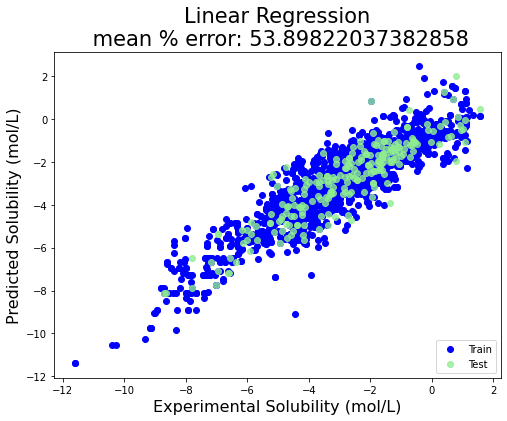

<Figure size 432x288 with 0 Axes>

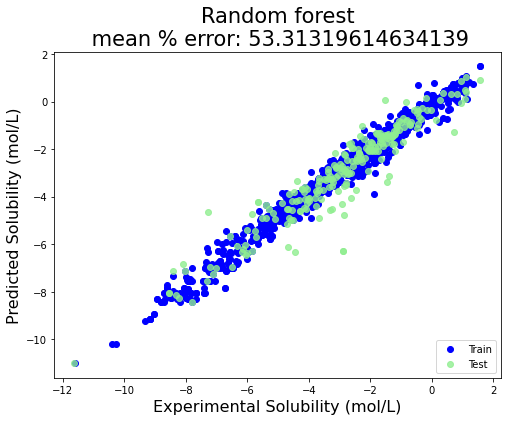

<Figure size 432x288 with 0 Axes>

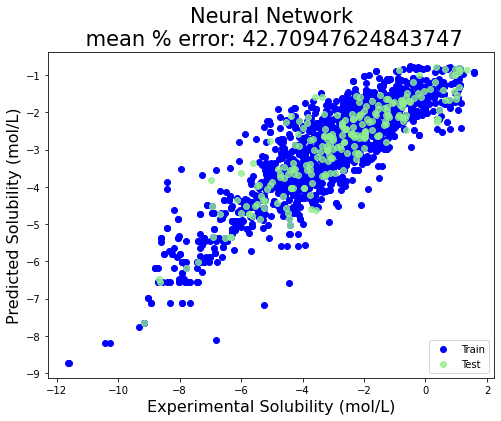

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
                 Random forest & 53.313 & 0.435 \\
                Neural Network & 42.709 & 0.882 \\
             Linear Regression & 53.898 & 702896103.480 \\
\end{tabular}


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

def make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, title='', figsize=(6,4), fontsize=16):    
    plt.clf()
    plt.figure(figsize=figsize)
    plt.scatter(y_train,y_pred_train, label = 'Train', c='blue')
    plt.title(title,fontsize=fontsize+5)
    plt.xlabel('Experimental Solubility (mol/L)', fontsize=fontsize)
    plt.ylabel('Predicted Solubility (mol/L)', fontsize=fontsize)
    plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8)
    plt.legend(loc=4)
    plt.show()

from sklearn.model_selection import train_test_split
def test_models_and_plot(x, y, model_dict, plots=True):
    ''' test a bunch of models and print out a sorted list of CV accuracies
        inputs: 
            x: training data features, numpy array or Pandas dataframe
            y: training data labels, numpy array or Pandas dataframe
            model_dict: a dictionary of the form {name : model()}, where 'name' is a string
                        and 'model()' is a scikit-learn model object. 
    '''

    mean_scores = {}
    percent_errors = {}

    for (name, model) in model_dict.items():
        #print("running %s" % name)
        scores = cross_val_score(model, x, y, cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
        scores = -1*scores
        mean_score = scores.mean()
        mean_scores[name] = mean_score

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)

        y_pred_test  = model.predict(X_test)

        percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))

        percent_errors[name] = percent_error

        fulltitle = name+'\n mean % error: '+str(percent_error)

        if plots:
            make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, title=fulltitle, figsize = (8,6))

    sorted_names = sorted(percent_errors, key=mean_scores.__getitem__, reverse=False)

    print("\\begin{tabular}{c c c}")
    print("           name     &      % test err   & .    abs error in CV \\\\ ")
    print("\\hline")
    for i in range(len(sorted_names)):
        name = sorted_names[i]
        print("%30s & %5.3f & %5.3f \\\\" % (name, percent_errors[name], mean_scores[name]))
    print("\\end{tabular}")


alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}

model_dict = {
            'Linear Regression': LinearRegression(),
            #'Kernel Ridge Regression': Best_KernelRidge,
            #'Ridge Regression':Best_Ridge,
            #'Gaussian Process Regressor': Best_GaussianProcessRegressor,
            #'Support Vector Regression': SVR(),
            #'KNeighborsRegressor': KNeighborsRegressor(),
            #'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100),
            'Random forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor(alpha=100,max_iter=8000, hidden_layer_sizes=[80,60], early_stopping=False),
            }

test_models_and_plot(X, y, model_dict)